# Fine-tuning - Denoising

We will use the pre-trained StorSeismic model to perform a denoising task. The input and output of the network are adjusted to noisy and clean seismic data, respectively.

## Load required modules

In [22]:
from transformers import BertConfig, BertForMaskedLM
import transformers
import torch.nn.functional as F
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from tqdm import tqdm
import os
import time
from radam import RAdam
import sys
import pandas as pd
import itertools

from storseismic.modules import *
from storseismic.train import run_denoising
from storseismic.utils import *

pd.set_option('display.max_rows', None)
torch.cuda.empty_cache()

params = {
    'savefig.dpi': 600,  # to adjust notebook inline plot size
    'figure.dpi' : 600,
    'axes.labelsize':14,  # fontsize for x and y labels (was 10)
    'axes.titlesize':14,
    'axes.titleweight': 'bold',
    'legend.fontsize': 14,  # was 10
    'xtick.labelsize':12,
    'ytick.labelsize':12,
    'font.family': 'serif',
}
matplotlib.rcParams.update(params)

## Initialization

### Fine-tuning configuration

In [2]:
config_path = "./results/pretrain/"
config = torch.load(os.path.join(config_path, 'config.pt'))

# Training Parameter
config.batch_size = 16
config.loss_fn = "l2" # "l2", "ssim", "ssiml1"
config.optim = "radam" # "adam", "radam"
config.lr = 5e-4
config.epoch = 1000
config.warmup = "none" if config.pre_ln else 0
config.patience = 20

# I/O parameter
config.parent_dir = './results/finetune/denoising/'
config.model_path = './results/pretrain/'
config.dataset = './data/finetune/'

print(config)

BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "batch_size": 16,
  "classifier_dropout": null,
  "dataset": "./data/finetune/",
  "embedding_type": "none",
  "epoch": 1000,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 256,
  "initializer_range": 0.02,
  "input_type": "trace",
  "intermediate_size": 1024,
  "layer_norm_eps": 1e-12,
  "loss_fn": "l2",
  "lr": 0.0005,
  "max_position_embeddings": 20,
  "model_path": "./results/pretrain/",
  "model_type": "bert",
  "num_attention_heads": 4,
  "num_hidden_ffn": 4,
  "num_hidden_layers": 4,
  "optim": "radam",
  "output_attentions": true,
  "output_hidden_states": true,
  "output_scores": true,
  "pad_token_id": 0,
  "parent_dir": "./results/finetune/denoising/",
  "patience": 20,
  "position_embedding_type": "sincos",
  "pre_ln": true,
  "transformers_version": "4.10.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 271,
  "warmup": "none"
}



### Load data and wrap in Pytorch DataLoader

In [3]:
train_data = torch.load(os.path.join(config.dataset, 'train_data.pt'))
test_data = torch.load(os.path.join(config.dataset, 'test_data.pt'))

vmin_all = -1
vmax_all = 1

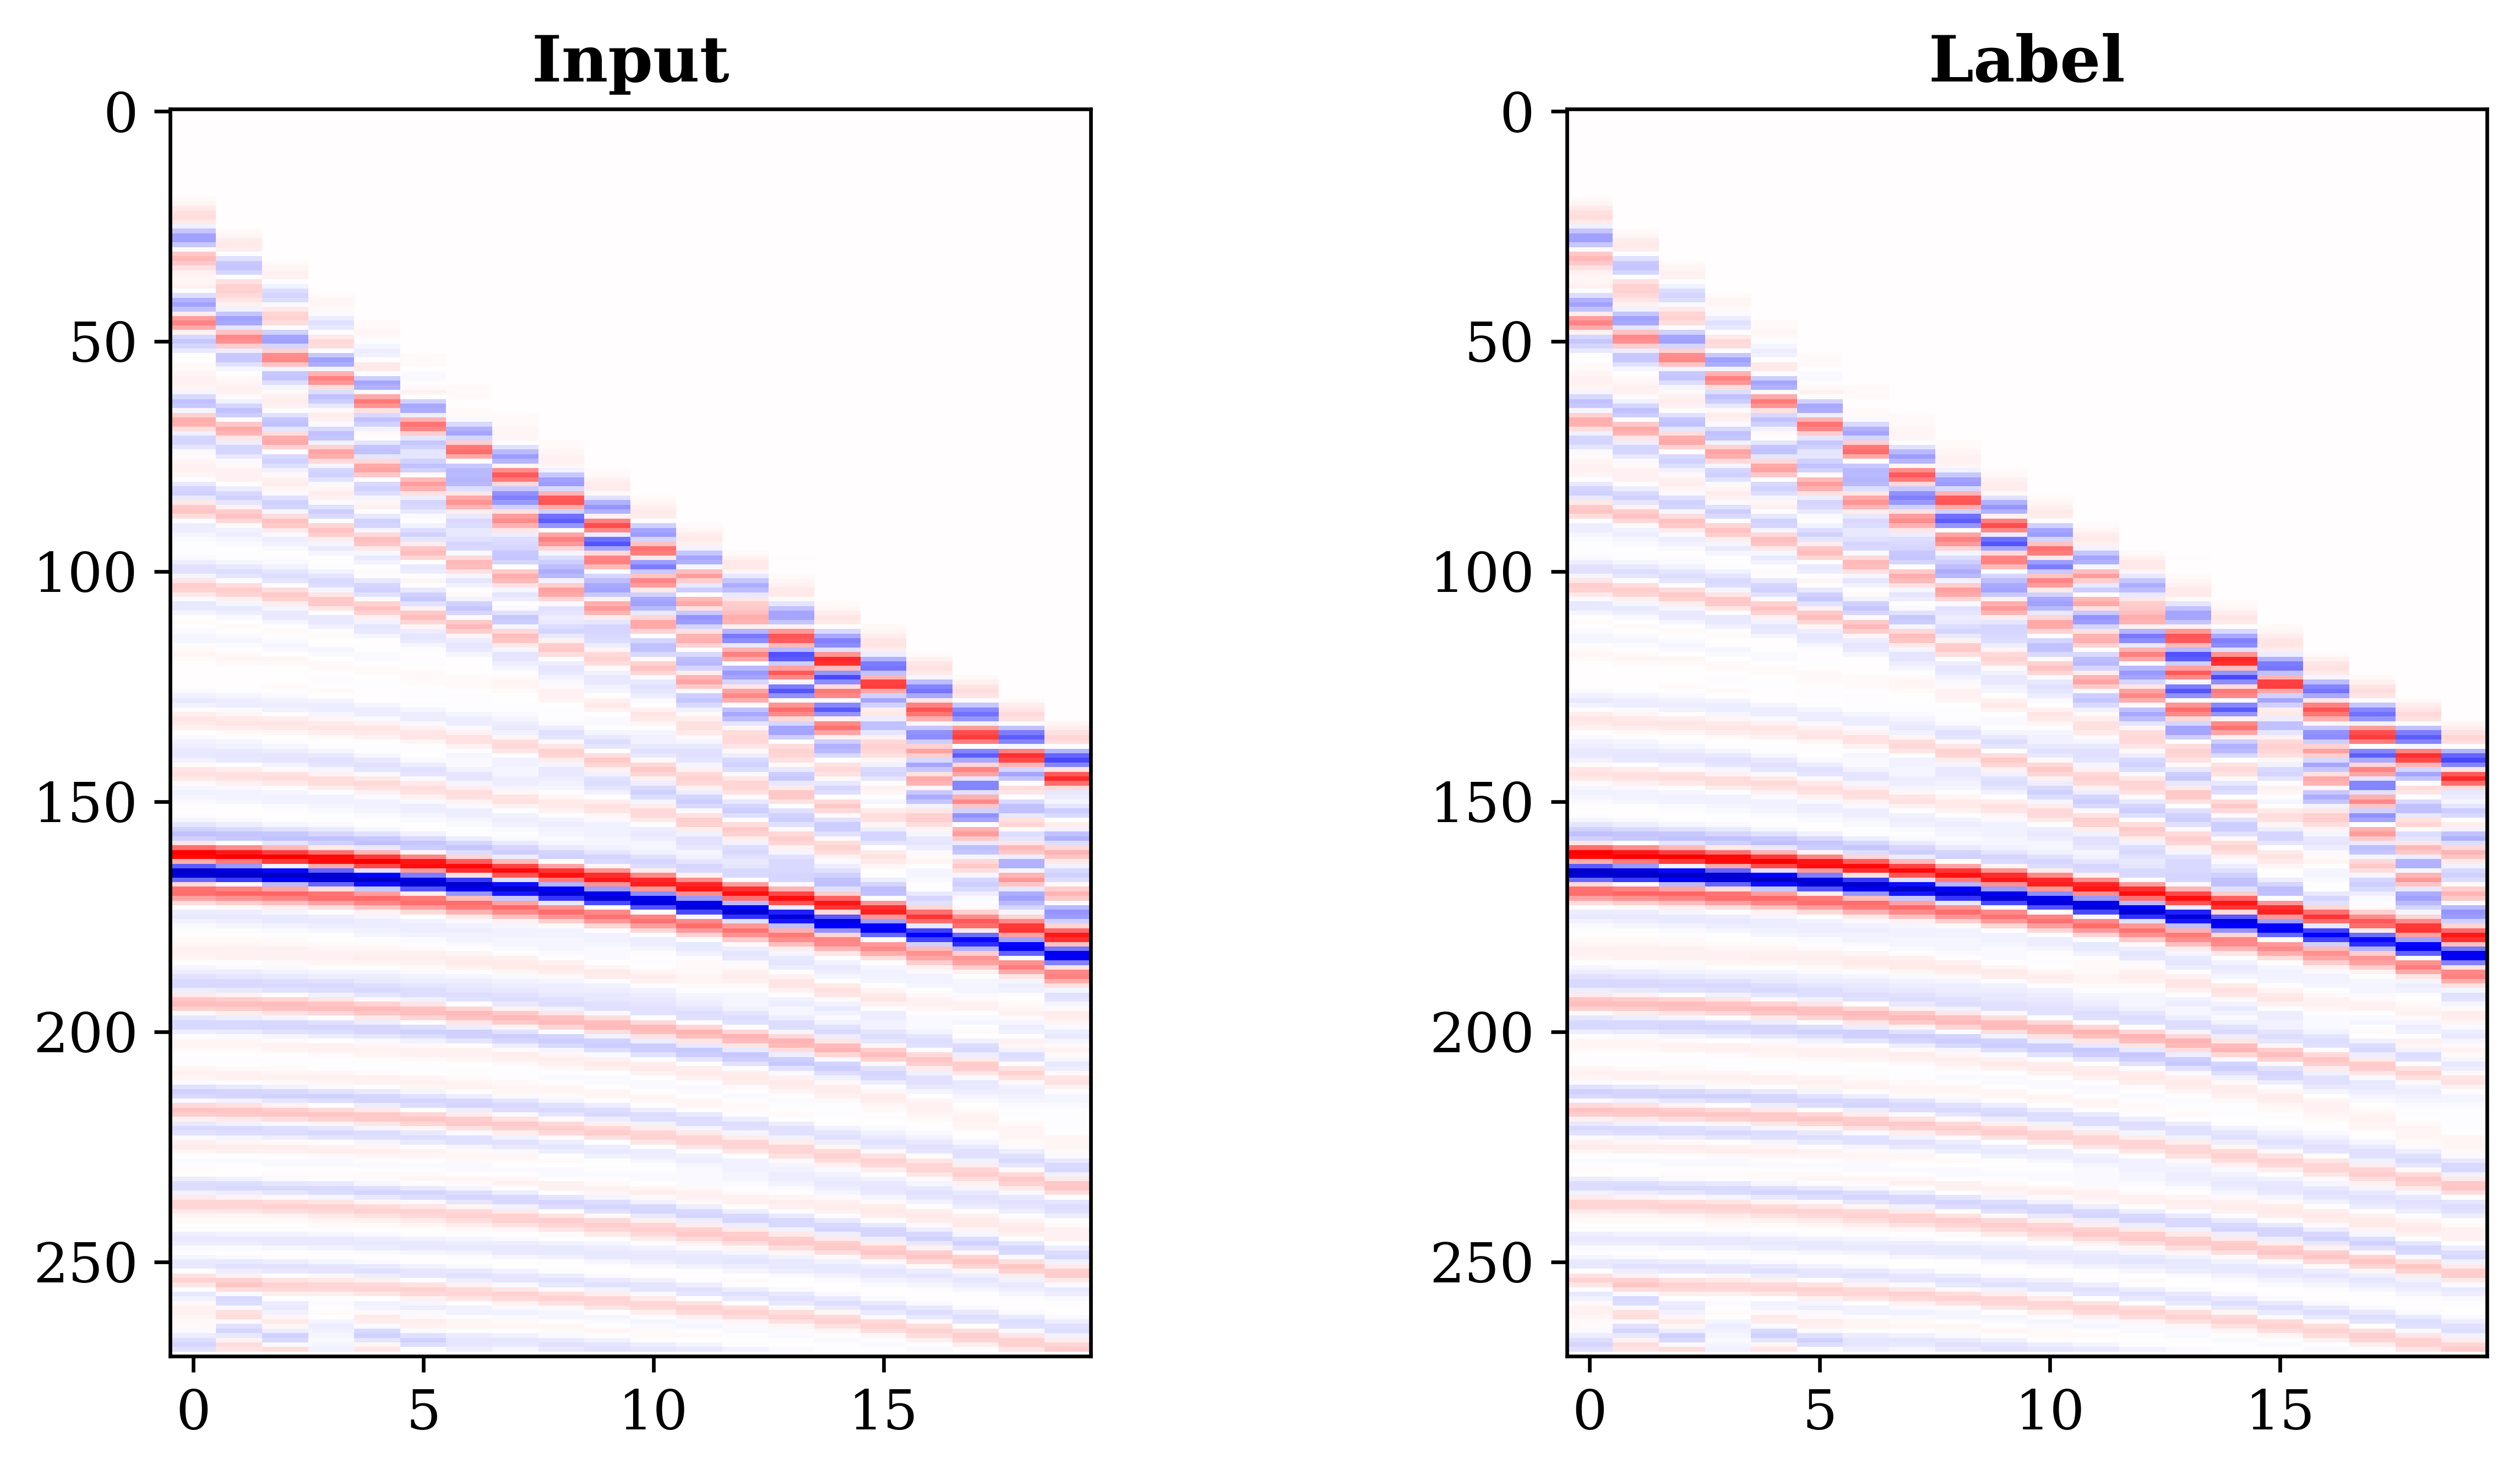

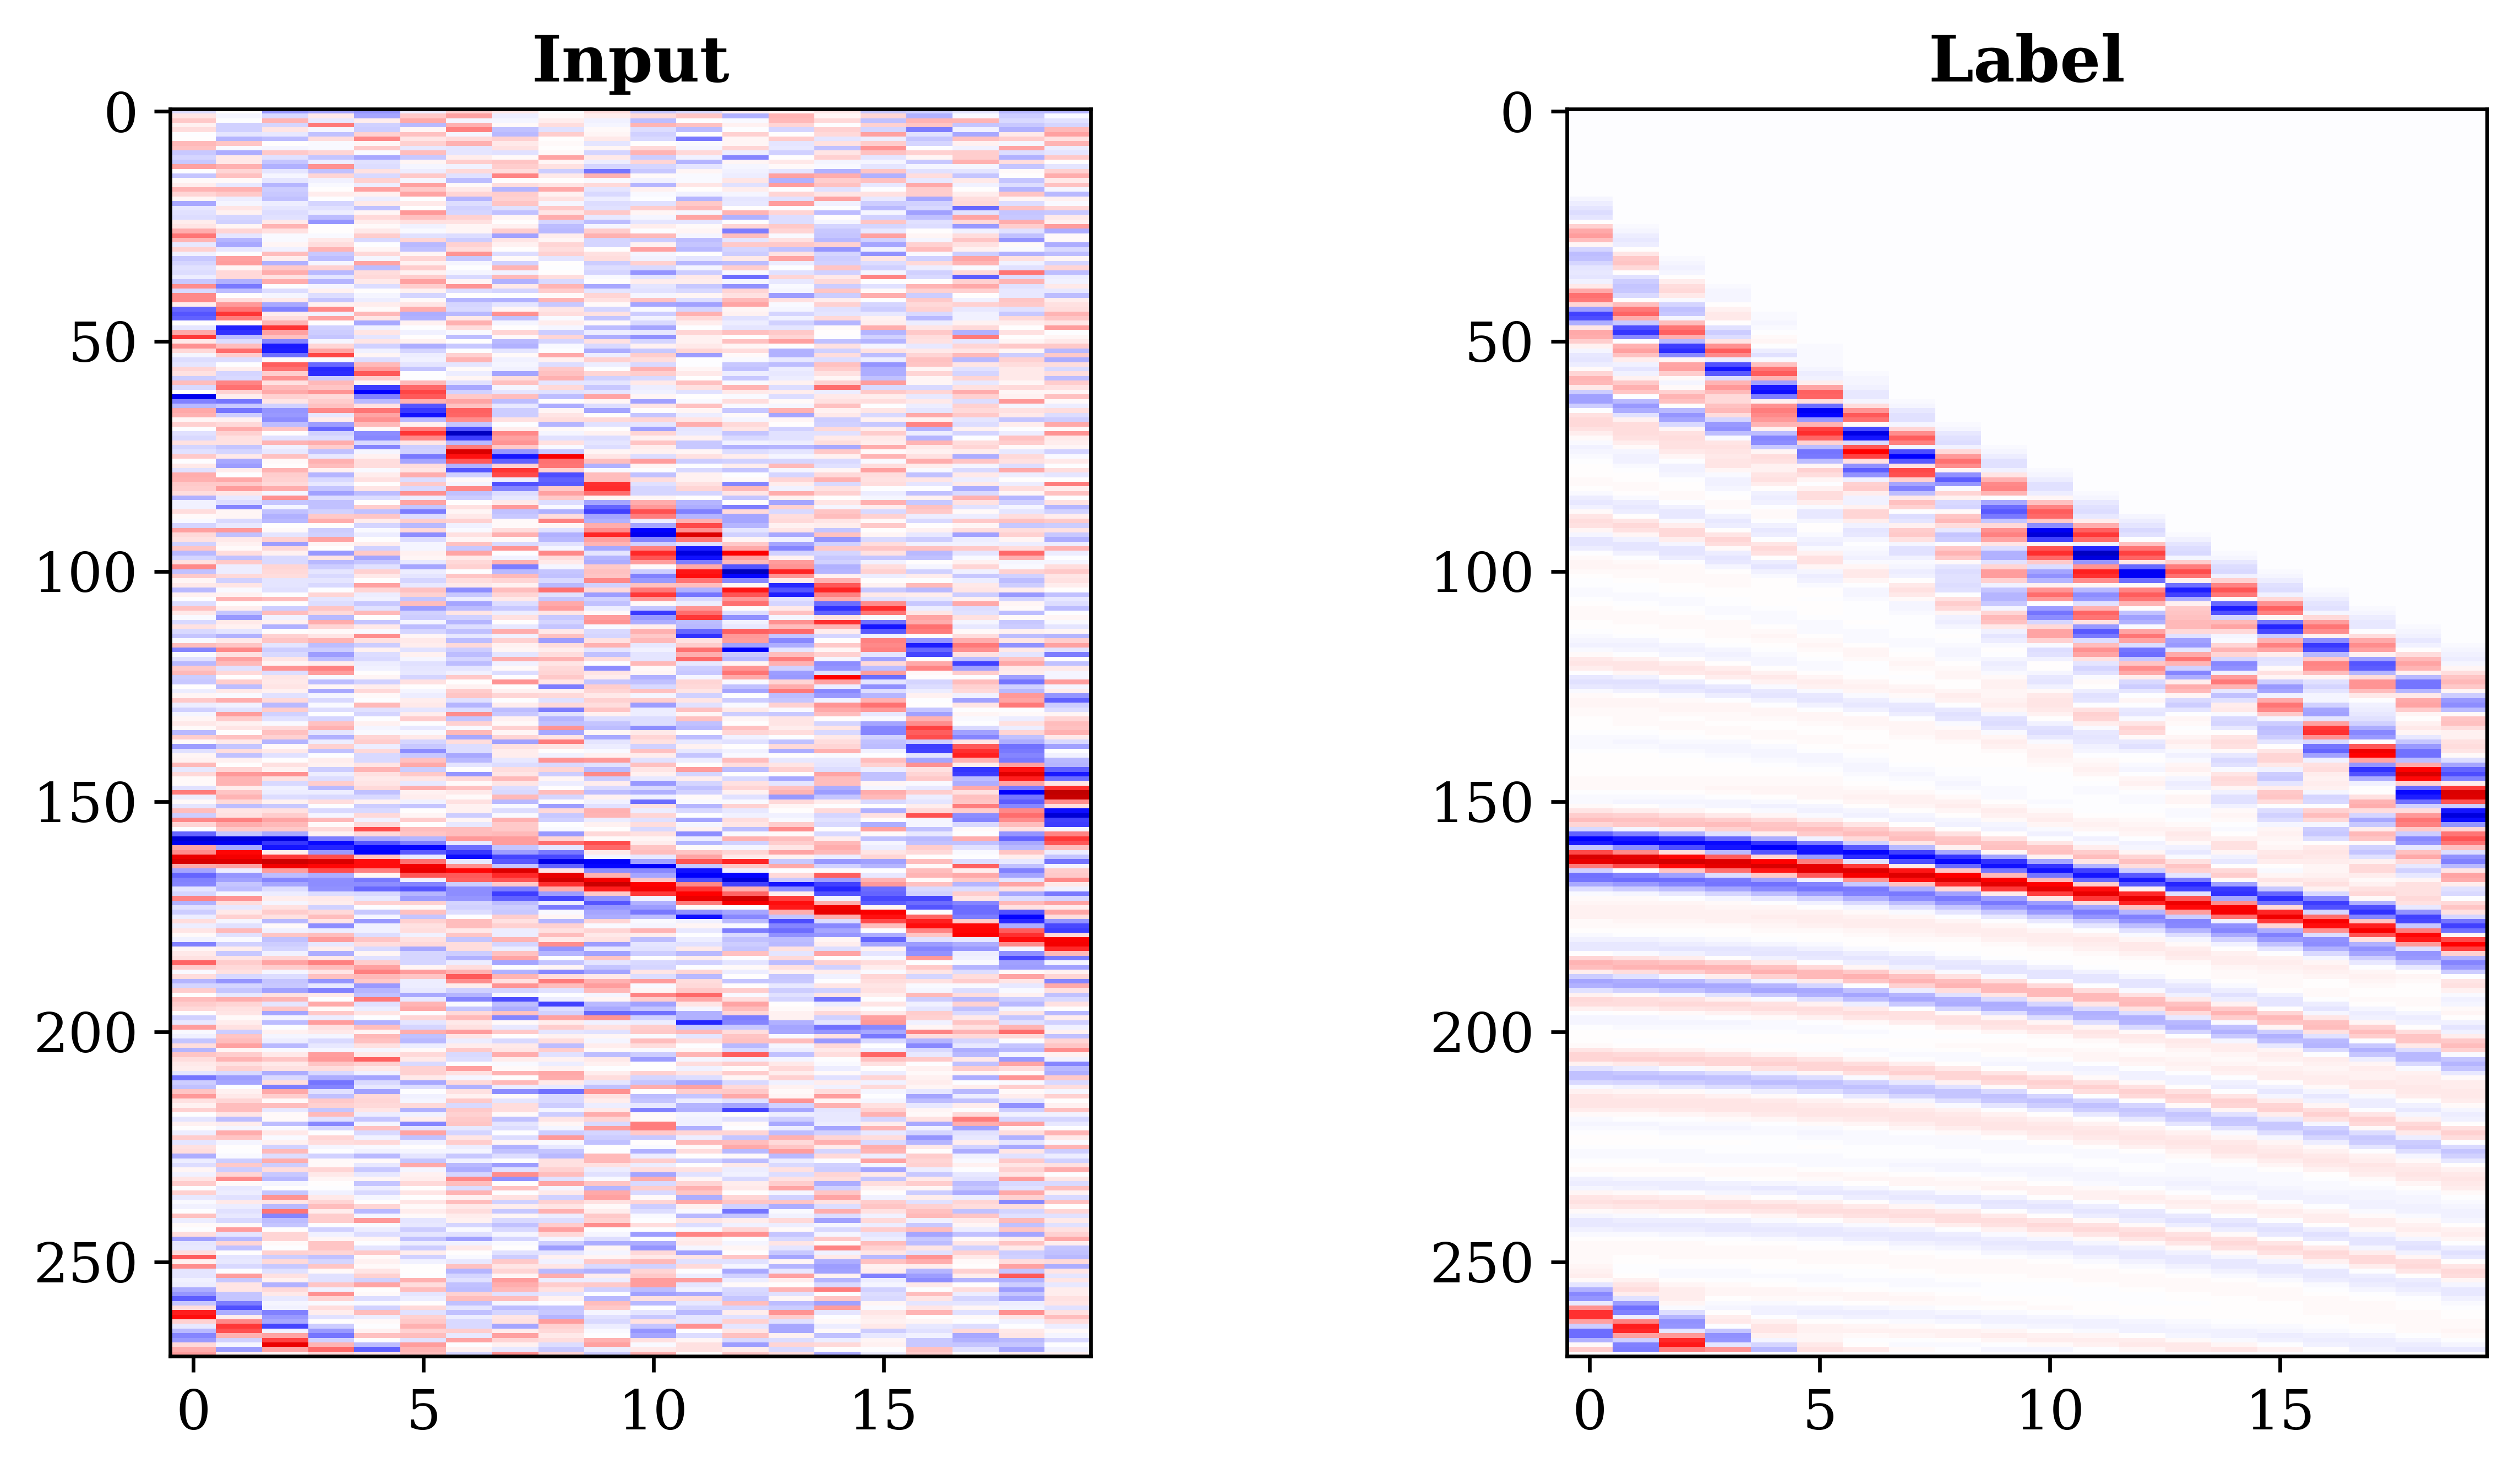

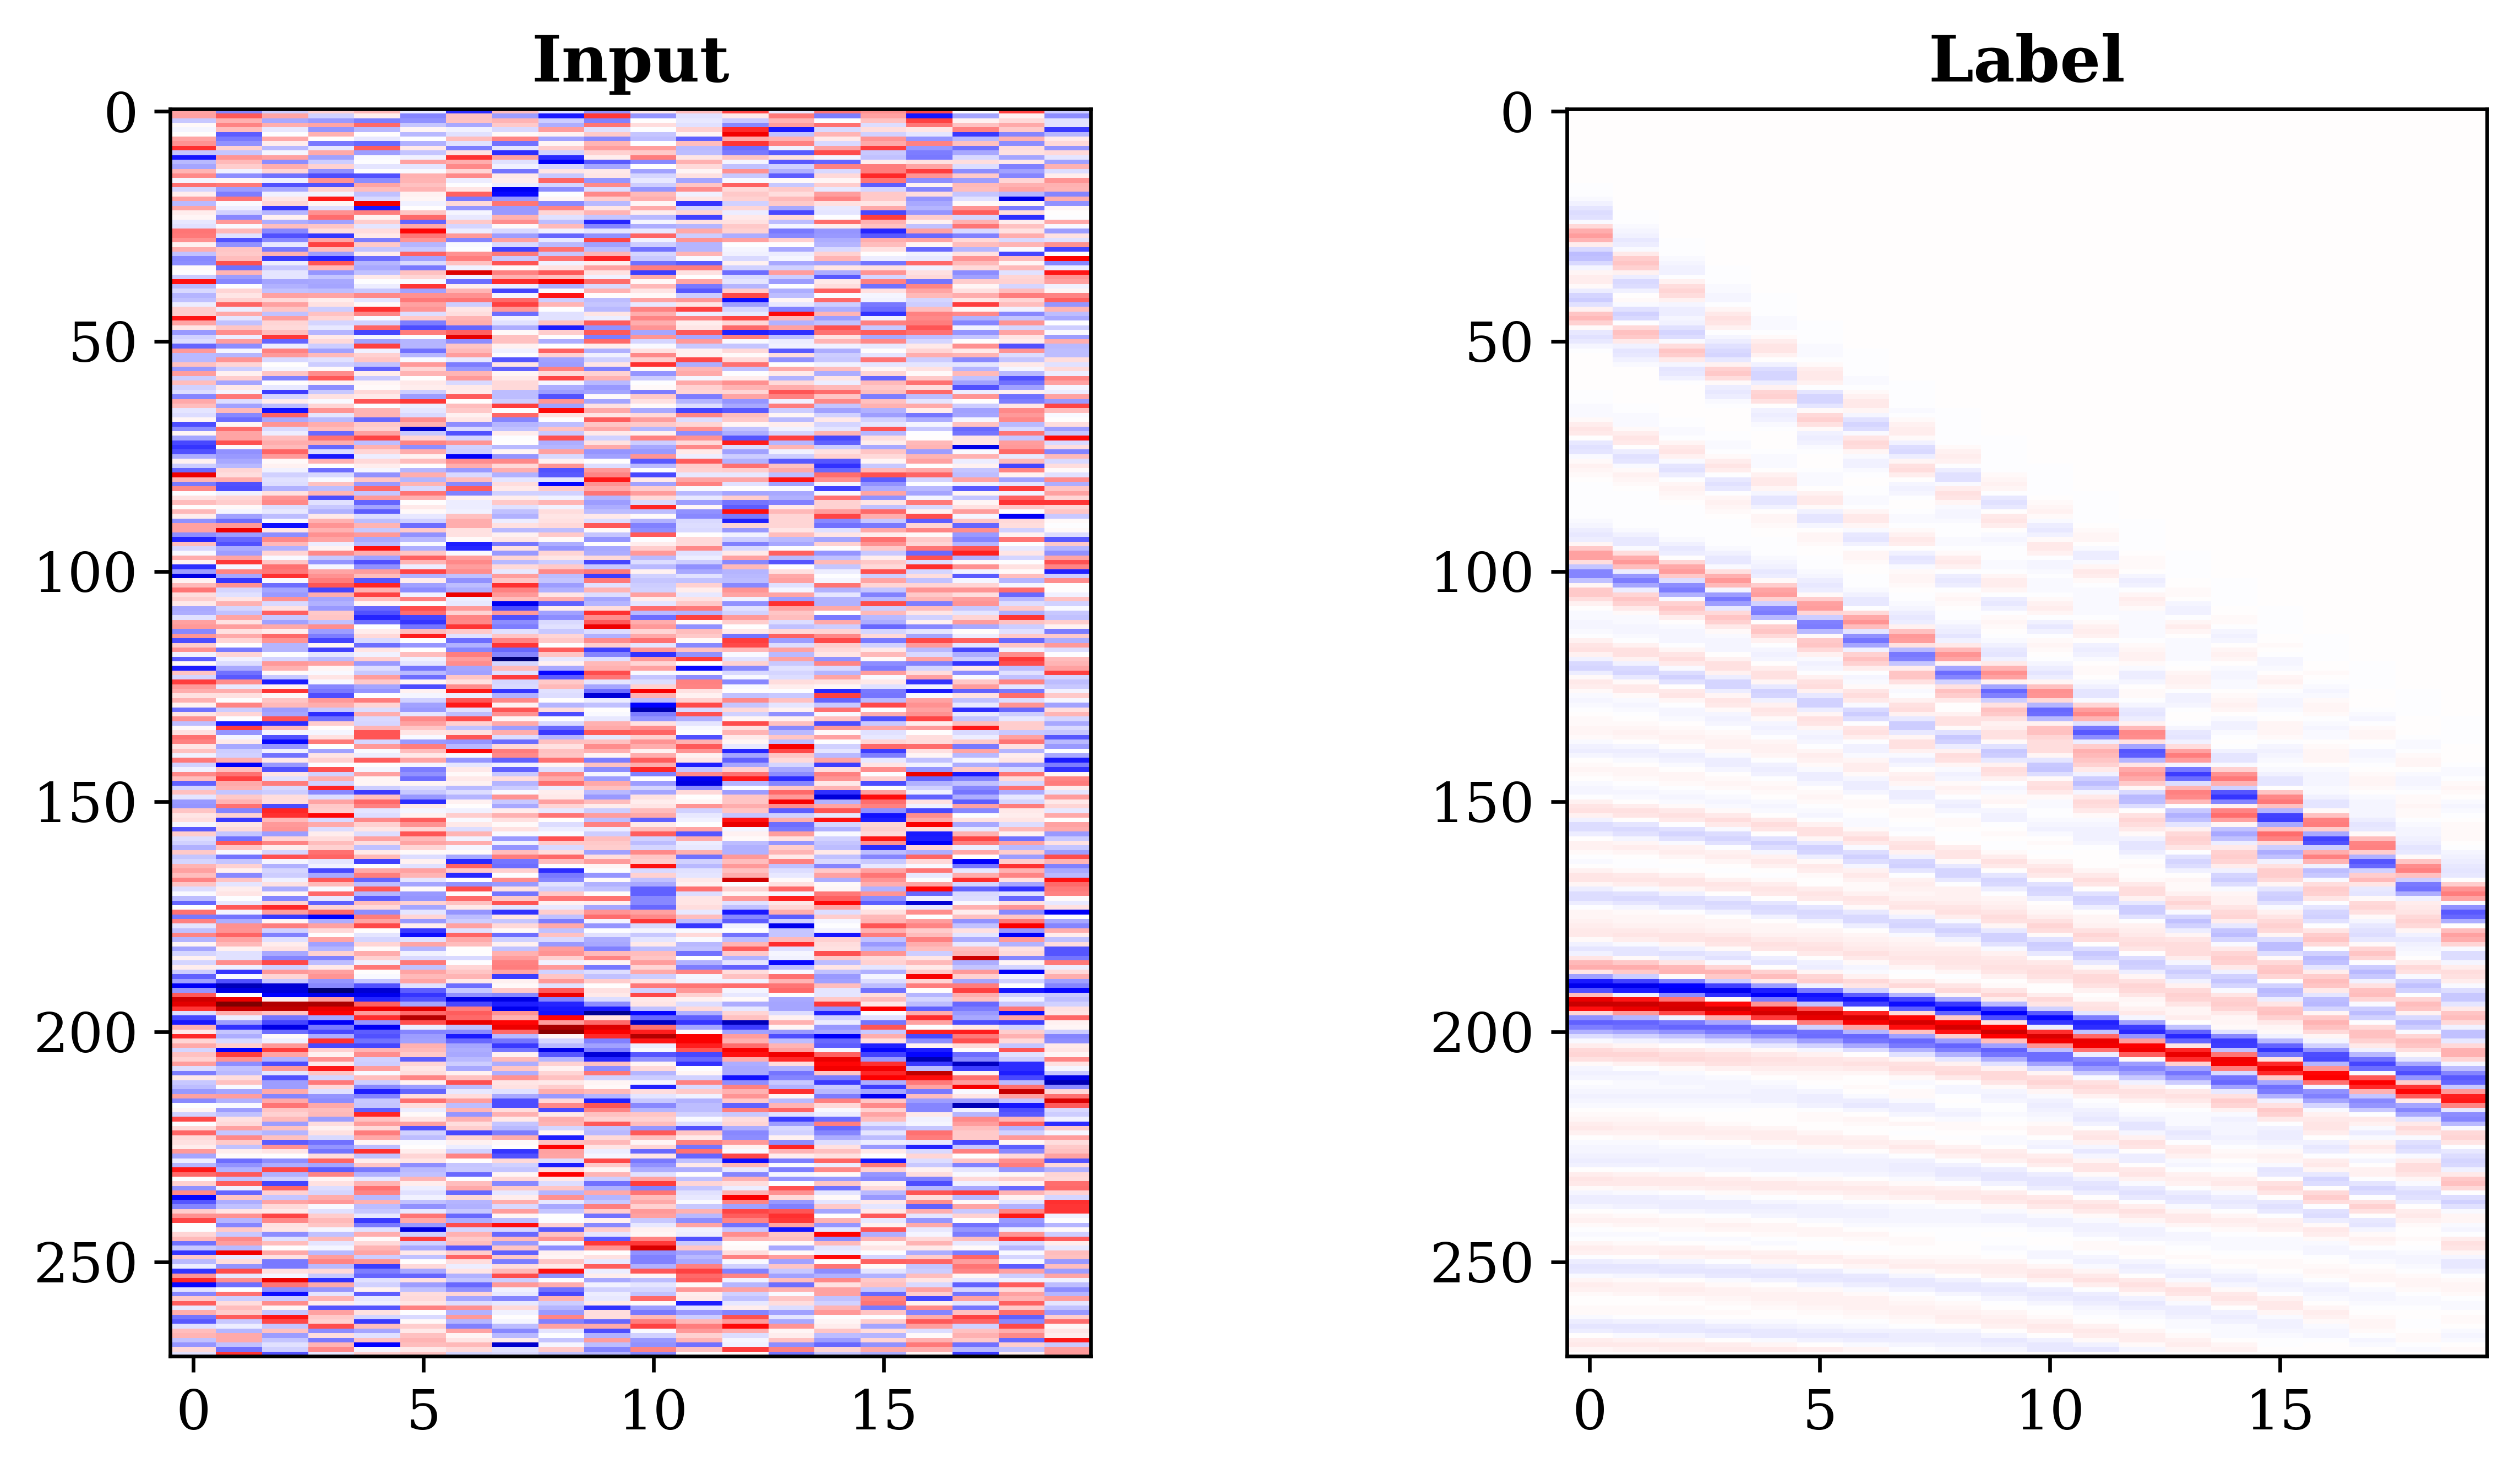

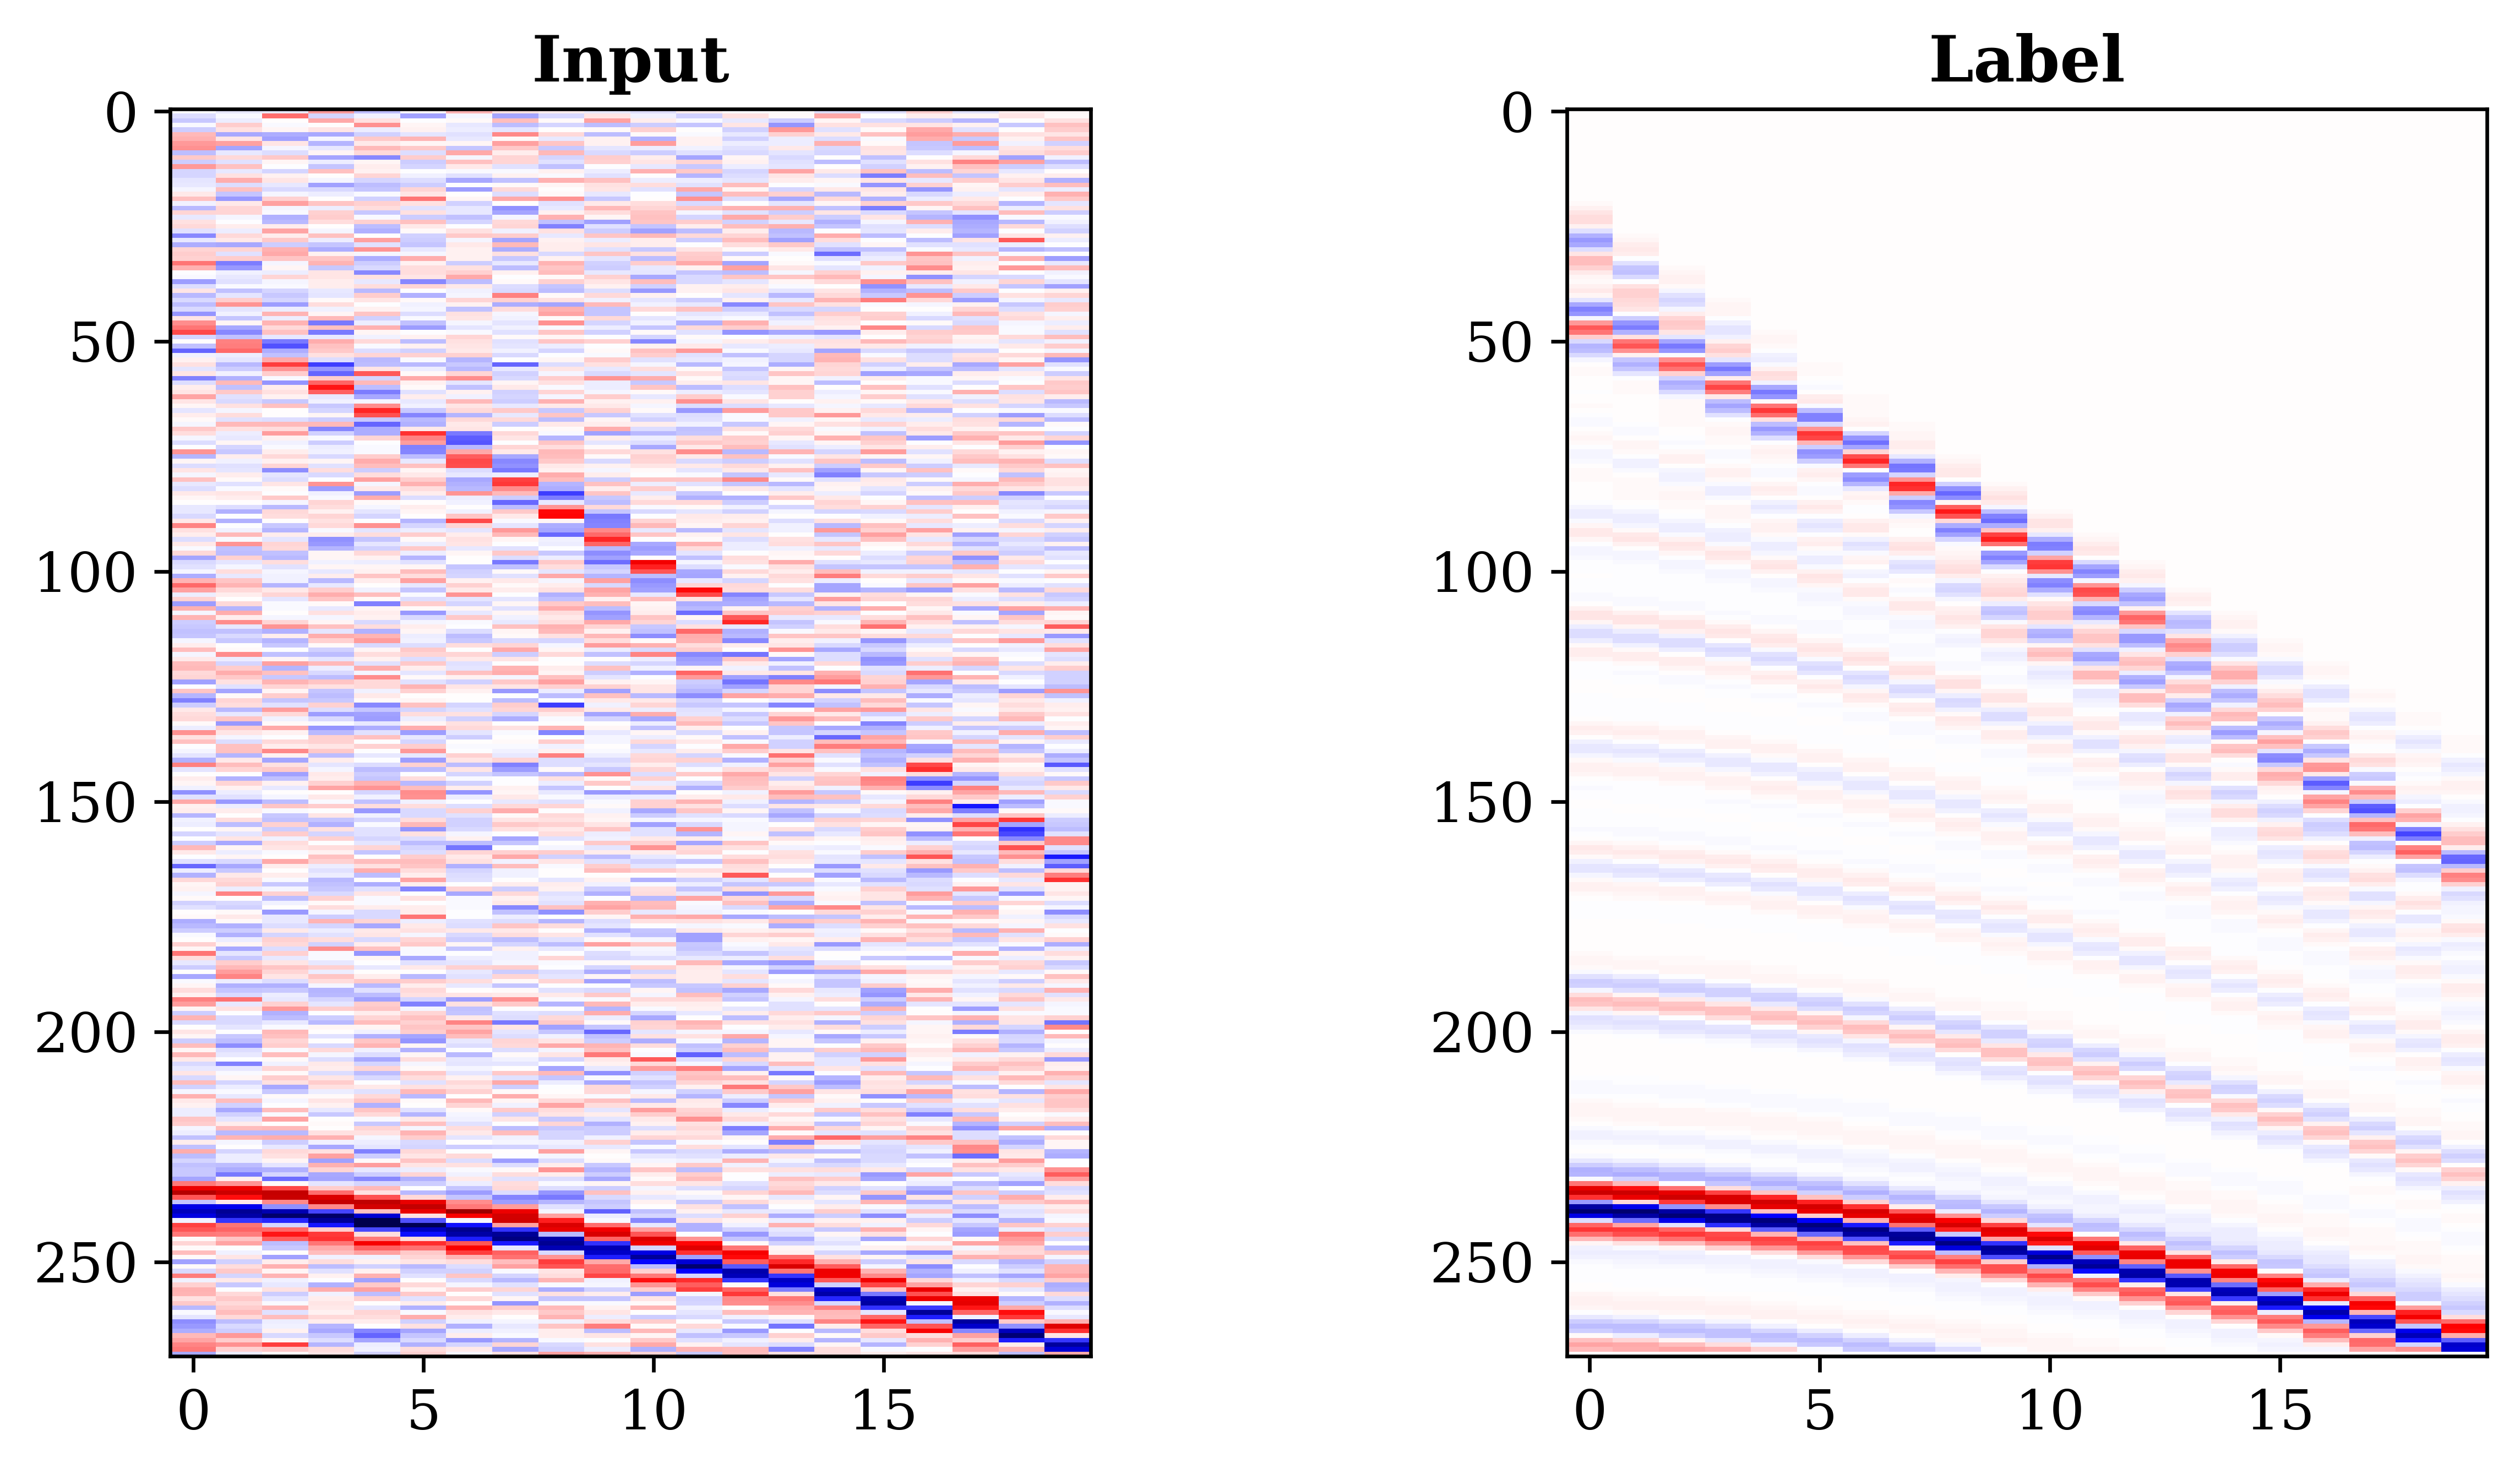

In [4]:
batch_size = config.batch_size

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

for i, X in enumerate(train_dataloader):
    if i == 0:
        for j in range(4):
            f, ax = plt.subplots(1, 2, figsize=(10, 5))
            ax[0].imshow(X['inputs_embeds'][j, :, :].swapaxes(0, 1) - X['inputs_embeds'][j, :, :].mean(), 
                         aspect=.1, vmin=vmin_all, vmax=vmax_all, cmap='seismic')
            ax[0].set_title("Input")
            ax[1].imshow(X['labels'][j, :, :].swapaxes(0, 1) - X['labels'][j, :, :].mean(), 
                         aspect=.1, vmin=vmin_all, vmax=vmax_all, cmap='seismic')
            ax[1].set_title("Label")

## Setup StorSeismic denoising model

In [15]:
if not os.path.exists(config.parent_dir):
    os.makedirs(config.parent_dir)

### Load pre-trained model

In [5]:
model = torch.load(os.path.join(config.model_path, "model.pt"))
print(model)

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Linear(in_features=271, out_features=256, bias=True)
      (position_embeddings): PositionalEncoding(
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): PreLNBertAttention(
            (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
            (self): BertSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): PreLNBertSelfOutput(
              (dense): Linear(in_feature

### Evaluate zero-shot performance

In [6]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

loss_fn = nn.MSELoss(reduction='mean')

loop_valid = tqdm(test_dataloader, leave=True)
losses_valid = 0
with torch.no_grad():
    for i, batch in enumerate(loop_valid):
        # pull all tensor batches required for training

        # Mask outside loop
        inputs_embeds = batch['inputs_embeds'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(inputs_embeds=inputs_embeds.to(device))
        
        loss = loss_fn(outputs.logits, labels)

        losses_valid += loss.item()

        loop_valid.set_description(f'Validation 0')
        loop_valid.set_postfix(loss=loss.item())
        
    avg_valid_loss = losses_valid / len(test_dataloader)

print("Zero-shot loss on test data: {}".format(avg_valid_loss))

Validation 0: 100%|█████████████████| 19/19 [00:00<00:00, 59.00it/s, loss=0.002]

Zero-shot loss on test data: 0.0014649715985318547


### Change the prediction head

In [7]:
model.cls = DenoisingHead(config)
print(model)

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Linear(in_features=271, out_features=256, bias=True)
      (position_embeddings): PositionalEncoding(
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): PreLNBertAttention(
            (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
            (self): BertSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): PreLNBertSelfOutput(
              (dense): Linear(in_feature

### Check number of trainable parameters

In [8]:
def count_parameters(model):
    table = pd.DataFrame(columns=['Name', 'Parameter'])
    total_params = 0
    i = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        total_params+=param
        table.loc[i] = [name] + [param]
        i += 1
    display(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(model)

,Name,Parameter
0,bert.embeddings.word_embeddings.weight,69376
1,bert.embeddings.word_embeddings.bias,256
2,bert.embeddings.LayerNorm.weight,256
3,bert.embeddings.LayerNorm.bias,256
4,bert.encoder.layer.0.attention.LayerNorm.weight,256
5,bert.encoder.layer.0.attention.LayerNorm.bias,256
6,bert.encoder.layer.0.attention.self.query.weight,65536
7,bert.encoder.layer.0.attention.self.query.bias,256
8,bert.encoder.layer.0.attention.self.key.weight,65536
9,bert.encoder.layer.0.attention.self.key.bias,256


Total Trainable Params: 3298831


3298831

#### Send model to device

In [9]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
print("Using device: {}".format(device))

Using device: cuda


## Training

### Set up training hyperparameters

In [10]:
# Optimizer
optim = RAdam(model.parameters(), lr=config.lr)

# Loss
loss_fn = nn.MSELoss(reduction='mean')

# Number of epochs
epochs = config.epoch

### Train

<IPython.core.display.Javascript object>


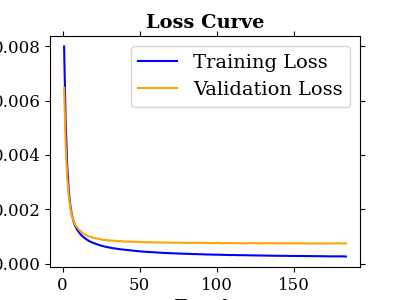

In [11]:
%matplotlib notebook

plt.ion()
f, ax = plt.subplots(figsize=(4, 3))

In [16]:
model, avg_train_loss, avg_valid_loss, time_per_epoch = \
run_denoising(model, optim, loss_fn, train_dataloader, test_dataloader, epochs, device, 
              tmp_dir=config.parent_dir, patience=config.patience, plot=True, f=f, ax=ax)

%matplotlib inline
plt.ioff()

Validation 0: 100%|██████████████| 19/19 [00:00<00:00, 155.99it/s, loss=0.00645]


Epoch time: 2.45 s
Total time elapsed: 2.45 s
---------------------------------------
Validation loss decreased (inf --> 0.006469).  Saving model ...


Validation 1: 100%|██████████████| 19/19 [00:00<00:00, 159.07it/s, loss=0.00498]


Epoch time: 2.39 s
Total time elapsed: 4.92 s
---------------------------------------
Validation loss decreased (0.006469 --> 0.004389).  Saving model ...


Validation 2: 100%|██████████████| 19/19 [00:00<00:00, 159.19it/s, loss=0.00327]


Epoch time: 2.42 s
Total time elapsed: 7.42 s
---------------------------------------
Validation loss decreased (0.004389 --> 0.003192).  Saving model ...


Validation 3: 100%|██████████████| 19/19 [00:00<00:00, 161.14it/s, loss=0.00244]


Epoch time: 2.42 s
Total time elapsed: 9.93 s
---------------------------------------
Validation loss decreased (0.003192 --> 0.002499).  Saving model ...


Validation 4: 100%|██████████████| 19/19 [00:00<00:00, 136.86it/s, loss=0.00255]


Epoch time: 2.45 s
Total time elapsed: 12.46 s
---------------------------------------
Validation loss decreased (0.002499 --> 0.002064).  Saving model ...


Validation 5: 100%|██████████████| 19/19 [00:00<00:00, 128.51it/s, loss=0.00155]


Epoch time: 2.45 s
Total time elapsed: 15.00 s
---------------------------------------
Validation loss decreased (0.002064 --> 0.001773).  Saving model ...


Validation 6: 100%|██████████████| 19/19 [00:00<00:00, 148.47it/s, loss=0.00118]


Epoch time: 2.72 s
Total time elapsed: 17.82 s
---------------------------------------
Validation loss decreased (0.001773 --> 0.001594).  Saving model ...


Validation 7: 100%|██████████████| 19/19 [00:00<00:00, 157.19it/s, loss=0.00161]


Epoch time: 2.45 s
Total time elapsed: 20.37 s
---------------------------------------
Validation loss decreased (0.001594 --> 0.001468).  Saving model ...


Validation 8: 100%|██████████████| 19/19 [00:00<00:00, 157.61it/s, loss=0.00149]


Epoch time: 2.44 s
Total time elapsed: 22.90 s
---------------------------------------
Validation loss decreased (0.001468 --> 0.001368).  Saving model ...


Validation 9: 100%|██████████████| 19/19 [00:00<00:00, 159.88it/s, loss=0.00132]


Epoch time: 2.40 s
Total time elapsed: 25.38 s
---------------------------------------
Validation loss decreased (0.001368 --> 0.001297).  Saving model ...


Validation 10: 100%|█████████████| 19/19 [00:00<00:00, 156.89it/s, loss=0.00154]


Epoch time: 2.41 s
Total time elapsed: 27.87 s
---------------------------------------
Validation loss decreased (0.001297 --> 0.001228).  Saving model ...


Validation 11: 100%|█████████████| 19/19 [00:00<00:00, 158.92it/s, loss=0.00145]


Epoch time: 2.41 s
Total time elapsed: 30.36 s
---------------------------------------
Validation loss decreased (0.001228 --> 0.001182).  Saving model ...


Validation 12: 100%|█████████████| 19/19 [00:00<00:00, 165.58it/s, loss=0.00121]


Epoch time: 2.39 s
Total time elapsed: 32.83 s
---------------------------------------
Validation loss decreased (0.001182 --> 0.001135).  Saving model ...


Validation 13: 100%|█████████████| 19/19 [00:00<00:00, 161.85it/s, loss=0.00106]


Epoch time: 2.39 s
Total time elapsed: 35.30 s
---------------------------------------
Validation loss decreased (0.001135 --> 0.001087).  Saving model ...


Validation 14: 100%|█████████████| 19/19 [00:00<00:00, 158.46it/s, loss=0.00102]


Epoch time: 2.42 s
Total time elapsed: 37.80 s
---------------------------------------
Validation loss decreased (0.001087 --> 0.001068).  Saving model ...


Validation 15: 100%|█████████████| 19/19 [00:00<00:00, 158.52it/s, loss=0.00131]


Epoch time: 2.40 s
Total time elapsed: 40.27 s
---------------------------------------
Validation loss decreased (0.001068 --> 0.001033).  Saving model ...


Validation 16: 100%|████████████| 19/19 [00:00<00:00, 163.02it/s, loss=0.000869]


Epoch time: 2.40 s
Total time elapsed: 42.75 s
---------------------------------------
Validation loss decreased (0.001033 --> 0.001001).  Saving model ...


Validation 17: 100%|█████████████| 19/19 [00:00<00:00, 158.02it/s, loss=0.00134]


Epoch time: 2.44 s
Total time elapsed: 45.27 s
---------------------------------------
Validation loss decreased (0.001001 --> 0.000987).  Saving model ...


Validation 18: 100%|█████████████| 19/19 [00:00<00:00, 162.42it/s, loss=0.00136]


Epoch time: 2.38 s
Total time elapsed: 47.73 s
---------------------------------------
Validation loss decreased (0.000987 --> 0.000975).  Saving model ...


Validation 19: 100%|████████████| 19/19 [00:00<00:00, 159.37it/s, loss=0.000904]


Epoch time: 2.40 s
Total time elapsed: 50.20 s
---------------------------------------
Validation loss decreased (0.000975 --> 0.000953).  Saving model ...


Validation 20: 100%|████████████| 19/19 [00:00<00:00, 154.81it/s, loss=0.000879]


Epoch time: 2.44 s
Total time elapsed: 52.74 s
---------------------------------------
Validation loss decreased (0.000953 --> 0.000936).  Saving model ...


Validation 21: 100%|█████████████| 19/19 [00:00<00:00, 161.96it/s, loss=0.00129]


Epoch time: 2.41 s
Total time elapsed: 55.23 s
---------------------------------------
Validation loss decreased (0.000936 --> 0.000926).  Saving model ...


Validation 22: 100%|████████████| 19/19 [00:00<00:00, 154.82it/s, loss=0.000969]


Epoch time: 2.39 s
Total time elapsed: 57.70 s
---------------------------------------
Validation loss decreased (0.000926 --> 0.000912).  Saving model ...


Validation 23: 100%|█████████████| 19/19 [00:00<00:00, 165.06it/s, loss=0.00085]


Epoch time: 2.40 s
Total time elapsed: 60.18 s
---------------------------------------
Validation loss decreased (0.000912 --> 0.000899).  Saving model ...


Validation 24: 100%|████████████| 19/19 [00:00<00:00, 155.45it/s, loss=0.000955]


Epoch time: 2.39 s
Total time elapsed: 62.65 s
---------------------------------------
Validation loss decreased (0.000899 --> 0.000892).  Saving model ...


Validation 25: 100%|████████████| 19/19 [00:00<00:00, 157.75it/s, loss=0.000917]


Epoch time: 2.41 s
Total time elapsed: 65.14 s
---------------------------------------
Validation loss decreased (0.000892 --> 0.000875).  Saving model ...


Validation 26: 100%|████████████| 19/19 [00:00<00:00, 157.51it/s, loss=0.000881]


Epoch time: 2.40 s
Total time elapsed: 67.63 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 27: 100%|████████████| 19/19 [00:00<00:00, 119.98it/s, loss=0.000885]


Epoch time: 2.45 s
Total time elapsed: 70.13 s
---------------------------------------
Validation loss decreased (0.000875 --> 0.000871).  Saving model ...


Validation 28: 100%|████████████| 19/19 [00:00<00:00, 143.61it/s, loss=0.000947]


Epoch time: 2.51 s
Total time elapsed: 72.72 s
---------------------------------------
Validation loss decreased (0.000871 --> 0.000863).  Saving model ...


Validation 29: 100%|████████████| 19/19 [00:00<00:00, 154.90it/s, loss=0.000788]


Epoch time: 2.44 s
Total time elapsed: 75.25 s
---------------------------------------
Validation loss decreased (0.000863 --> 0.000848).  Saving model ...


Validation 30: 100%|████████████| 19/19 [00:00<00:00, 154.50it/s, loss=0.000732]


Epoch time: 2.42 s
Total time elapsed: 77.74 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 31: 100%|█████████████| 19/19 [00:00<00:00, 156.82it/s, loss=0.00105]


Epoch time: 2.41 s
Total time elapsed: 80.20 s
---------------------------------------
Validation loss decreased (0.000848 --> 0.000845).  Saving model ...


Validation 32: 100%|████████████| 19/19 [00:00<00:00, 136.75it/s, loss=0.000971]


Epoch time: 2.43 s
Total time elapsed: 82.71 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 33: 100%|████████████| 19/19 [00:00<00:00, 131.78it/s, loss=0.000788]


Epoch time: 2.48 s
Total time elapsed: 85.25 s
---------------------------------------
Validation loss decreased (0.000845 --> 0.000839).  Saving model ...


Validation 34: 100%|████████████| 19/19 [00:00<00:00, 158.43it/s, loss=0.000789]


Epoch time: 2.42 s
Total time elapsed: 87.74 s
---------------------------------------
Validation loss decreased (0.000839 --> 0.000828).  Saving model ...


Validation 35: 100%|████████████| 19/19 [00:00<00:00, 155.35it/s, loss=0.000838]


Epoch time: 2.39 s
Total time elapsed: 90.21 s
---------------------------------------
Validation loss decreased (0.000828 --> 0.000828).  Saving model ...


Validation 36: 100%|████████████| 19/19 [00:00<00:00, 157.69it/s, loss=0.000929]


Epoch time: 2.48 s
Total time elapsed: 92.77 s
---------------------------------------
Validation loss decreased (0.000828 --> 0.000822).  Saving model ...


Validation 37: 100%|████████████| 19/19 [00:00<00:00, 157.49it/s, loss=0.000969]


Epoch time: 2.47 s
Total time elapsed: 95.32 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 38: 100%|█████████████| 19/19 [00:00<00:00, 150.98it/s, loss=0.00107]


Epoch time: 2.73 s
Total time elapsed: 98.10 s
---------------------------------------
Validation loss decreased (0.000822 --> 0.000818).  Saving model ...


Validation 39: 100%|████████████| 19/19 [00:00<00:00, 151.27it/s, loss=0.000784]


Epoch time: 2.99 s
Total time elapsed: 101.18 s
---------------------------------------
Validation loss decreased (0.000818 --> 0.000810).  Saving model ...


Validation 40: 100%|████████████| 19/19 [00:00<00:00, 152.28it/s, loss=0.000788]


Epoch time: 2.95 s
Total time elapsed: 104.21 s
---------------------------------------
Validation loss decreased (0.000810 --> 0.000805).  Saving model ...


Validation 41: 100%|████████████| 19/19 [00:00<00:00, 155.93it/s, loss=0.000956]


Epoch time: 2.95 s
Total time elapsed: 107.23 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 42: 100%|████████████| 19/19 [00:00<00:00, 156.09it/s, loss=0.000895]


Epoch time: 2.89 s
Total time elapsed: 110.18 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 43: 100%|████████████| 19/19 [00:00<00:00, 154.43it/s, loss=0.000821]


Epoch time: 2.94 s
Total time elapsed: 113.17 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 44: 100%|████████████| 19/19 [00:00<00:00, 156.77it/s, loss=0.000906]


Epoch time: 2.87 s
Total time elapsed: 116.10 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 45: 100%|█████████████| 19/19 [00:00<00:00, 129.84it/s, loss=0.00074]


Epoch time: 2.97 s
Total time elapsed: 119.12 s
---------------------------------------
Validation loss decreased (0.000805 --> 0.000793).  Saving model ...


Validation 46: 100%|████████████| 19/19 [00:00<00:00, 160.56it/s, loss=0.000787]


Epoch time: 2.43 s
Total time elapsed: 121.63 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 47: 100%|████████████| 19/19 [00:00<00:00, 158.70it/s, loss=0.000627]


Epoch time: 2.42 s
Total time elapsed: 124.11 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 48: 100%|████████████| 19/19 [00:00<00:00, 157.86it/s, loss=0.000712]


Epoch time: 2.41 s
Total time elapsed: 126.57 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 49: 100%|████████████| 19/19 [00:00<00:00, 163.98it/s, loss=0.000814]


Epoch time: 2.39 s
Total time elapsed: 129.03 s
---------------------------------------
Validation loss decreased (0.000793 --> 0.000792).  Saving model ...


Validation 50: 100%|█████████████| 19/19 [00:00<00:00, 157.58it/s, loss=0.00101]


Epoch time: 2.44 s
Total time elapsed: 131.61 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 51: 100%|████████████| 19/19 [00:00<00:00, 157.47it/s, loss=0.000579]


Epoch time: 2.43 s
Total time elapsed: 134.09 s
---------------------------------------
Validation loss decreased (0.000792 --> 0.000784).  Saving model ...


Validation 52: 100%|████████████| 19/19 [00:00<00:00, 152.89it/s, loss=0.000771]


Epoch time: 2.41 s
Total time elapsed: 136.58 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 53: 100%|████████████| 19/19 [00:00<00:00, 158.03it/s, loss=0.000666]


Epoch time: 2.41 s
Total time elapsed: 139.04 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 54: 100%|████████████| 19/19 [00:00<00:00, 157.01it/s, loss=0.000798]


Epoch time: 2.41 s
Total time elapsed: 141.51 s
---------------------------------------
Validation loss decreased (0.000784 --> 0.000784).  Saving model ...


Validation 55: 100%|████████████| 19/19 [00:00<00:00, 159.17it/s, loss=0.000833]


Epoch time: 2.44 s
Total time elapsed: 144.03 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 56: 100%|████████████| 19/19 [00:00<00:00, 163.21it/s, loss=0.000768]


Epoch time: 2.40 s
Total time elapsed: 146.49 s
---------------------------------------
Validation loss decreased (0.000784 --> 0.000783).  Saving model ...


Validation 57: 100%|████████████| 19/19 [00:00<00:00, 157.72it/s, loss=0.000787]


Epoch time: 2.40 s
Total time elapsed: 148.96 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 58: 100%|████████████| 19/19 [00:00<00:00, 158.03it/s, loss=0.000836]


Epoch time: 2.39 s
Total time elapsed: 151.40 s
---------------------------------------
Validation loss decreased (0.000783 --> 0.000778).  Saving model ...


Validation 59: 100%|████████████| 19/19 [00:00<00:00, 156.52it/s, loss=0.000557]


Epoch time: 2.41 s
Total time elapsed: 153.89 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 60: 100%|████████████| 19/19 [00:00<00:00, 156.64it/s, loss=0.000881]


Epoch time: 2.39 s
Total time elapsed: 156.34 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 61: 100%|████████████| 19/19 [00:00<00:00, 155.66it/s, loss=0.000607]


Epoch time: 2.41 s
Total time elapsed: 158.80 s
---------------------------------------
Validation loss decreased (0.000778 --> 0.000773).  Saving model ...


Validation 62: 100%|████████████| 19/19 [00:00<00:00, 161.45it/s, loss=0.000619]


Epoch time: 2.42 s
Total time elapsed: 161.30 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 63: 100%|████████████| 19/19 [00:00<00:00, 160.56it/s, loss=0.000839]


Epoch time: 2.39 s
Total time elapsed: 163.75 s
---------------------------------------
Validation loss decreased (0.000773 --> 0.000772).  Saving model ...


Validation 64: 100%|████████████| 19/19 [00:00<00:00, 154.67it/s, loss=0.000898]


Epoch time: 2.43 s
Total time elapsed: 166.25 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 65: 100%|████████████| 19/19 [00:00<00:00, 157.93it/s, loss=0.000765]


Epoch time: 2.40 s
Total time elapsed: 168.70 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 66: 100%|█████████████| 19/19 [00:00<00:00, 151.99it/s, loss=0.00109]


Epoch time: 2.40 s
Total time elapsed: 171.15 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 67: 100%|████████████| 19/19 [00:00<00:00, 155.89it/s, loss=0.000892]


Epoch time: 2.41 s
Total time elapsed: 173.62 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 68: 100%|████████████| 19/19 [00:00<00:00, 158.04it/s, loss=0.000637]


Epoch time: 2.39 s
Total time elapsed: 176.06 s
---------------------------------------
EarlyStopping counter: 5 out of 20


Validation 69: 100%|████████████| 19/19 [00:00<00:00, 157.44it/s, loss=0.000659]


Epoch time: 2.40 s
Total time elapsed: 178.52 s
---------------------------------------
Validation loss decreased (0.000772 --> 0.000769).  Saving model ...


Validation 70: 100%|████████████| 19/19 [00:00<00:00, 163.69it/s, loss=0.000791]


Epoch time: 2.39 s
Total time elapsed: 180.99 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 71: 100%|████████████| 19/19 [00:00<00:00, 166.69it/s, loss=0.000682]


Epoch time: 2.42 s
Total time elapsed: 183.46 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 72: 100%|████████████| 19/19 [00:00<00:00, 158.34it/s, loss=0.000615]


Epoch time: 2.39 s
Total time elapsed: 185.90 s
---------------------------------------
Validation loss decreased (0.000769 --> 0.000765).  Saving model ...


Validation 73: 100%|████████████| 19/19 [00:00<00:00, 161.04it/s, loss=0.000653]


Epoch time: 2.40 s
Total time elapsed: 188.38 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 74: 100%|████████████| 19/19 [00:00<00:00, 162.08it/s, loss=0.000559]


Epoch time: 2.39 s
Total time elapsed: 190.83 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 75: 100%|████████████| 19/19 [00:00<00:00, 162.96it/s, loss=0.000682]


Epoch time: 2.39 s
Total time elapsed: 193.27 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 76: 100%|████████████| 19/19 [00:00<00:00, 141.49it/s, loss=0.000672]


Epoch time: 2.43 s
Total time elapsed: 195.75 s
---------------------------------------
Validation loss decreased (0.000765 --> 0.000763).  Saving model ...


Validation 77: 100%|████████████| 19/19 [00:00<00:00, 158.96it/s, loss=0.000853]


Epoch time: 2.39 s
Total time elapsed: 198.24 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 78: 100%|████████████| 19/19 [00:00<00:00, 157.46it/s, loss=0.000855]


Epoch time: 2.40 s
Total time elapsed: 200.69 s
---------------------------------------
Validation loss decreased (0.000763 --> 0.000759).  Saving model ...


Validation 79: 100%|████████████| 19/19 [00:00<00:00, 152.53it/s, loss=0.000658]


Epoch time: 2.43 s
Total time elapsed: 203.20 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 80: 100%|████████████| 19/19 [00:00<00:00, 149.77it/s, loss=0.000797]


Epoch time: 2.41 s
Total time elapsed: 205.67 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 81: 100%|████████████| 19/19 [00:00<00:00, 118.90it/s, loss=0.000701]


Epoch time: 2.43 s
Total time elapsed: 208.16 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 82: 100%|████████████| 19/19 [00:00<00:00, 134.88it/s, loss=0.000463]


Epoch time: 2.42 s
Total time elapsed: 210.65 s
---------------------------------------
Validation loss decreased (0.000759 --> 0.000759).  Saving model ...


Validation 83: 100%|████████████| 19/19 [00:00<00:00, 157.26it/s, loss=0.000867]


Epoch time: 2.42 s
Total time elapsed: 213.15 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 84: 100%|████████████| 19/19 [00:00<00:00, 167.72it/s, loss=0.000618]


Epoch time: 2.40 s
Total time elapsed: 215.61 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 85: 100%|█████████████| 19/19 [00:00<00:00, 159.92it/s, loss=0.00085]


Epoch time: 2.40 s
Total time elapsed: 218.06 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 86: 100%|████████████| 19/19 [00:00<00:00, 145.85it/s, loss=0.000933]


Epoch time: 2.41 s
Total time elapsed: 220.53 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 87: 100%|████████████| 19/19 [00:00<00:00, 160.63it/s, loss=0.000706]


Epoch time: 2.41 s
Total time elapsed: 223.00 s
---------------------------------------
EarlyStopping counter: 5 out of 20


Validation 88: 100%|████████████| 19/19 [00:00<00:00, 155.79it/s, loss=0.000911]


Epoch time: 2.42 s
Total time elapsed: 225.48 s
---------------------------------------
EarlyStopping counter: 6 out of 20


Validation 89: 100%|████████████| 19/19 [00:00<00:00, 166.52it/s, loss=0.000782]


Epoch time: 2.39 s
Total time elapsed: 227.93 s
---------------------------------------
EarlyStopping counter: 7 out of 20


Validation 90: 100%|████████████| 19/19 [00:00<00:00, 134.87it/s, loss=0.000891]


Epoch time: 2.42 s
Total time elapsed: 230.40 s
---------------------------------------
EarlyStopping counter: 8 out of 20


Validation 91: 100%|████████████| 19/19 [00:00<00:00, 156.63it/s, loss=0.000624]


Epoch time: 2.40 s
Total time elapsed: 232.86 s
---------------------------------------
EarlyStopping counter: 9 out of 20


Validation 92: 100%|████████████| 19/19 [00:00<00:00, 160.20it/s, loss=0.000614]


Epoch time: 2.40 s
Total time elapsed: 235.32 s
---------------------------------------
Validation loss decreased (0.000759 --> 0.000755).  Saving model ...


Validation 93: 100%|████████████| 19/19 [00:00<00:00, 134.56it/s, loss=0.000782]


Epoch time: 2.45 s
Total time elapsed: 237.85 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 94: 100%|████████████| 19/19 [00:00<00:00, 161.11it/s, loss=0.000741]


Epoch time: 2.40 s
Total time elapsed: 240.31 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 95: 100%|████████████| 19/19 [00:00<00:00, 155.74it/s, loss=0.000888]


Epoch time: 2.43 s
Total time elapsed: 242.80 s
---------------------------------------
Validation loss decreased (0.000755 --> 0.000753).  Saving model ...


Validation 96: 100%|████████████| 19/19 [00:00<00:00, 158.72it/s, loss=0.000938]


Epoch time: 2.43 s
Total time elapsed: 245.32 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 97: 100%|█████████████| 19/19 [00:00<00:00, 157.94it/s, loss=0.00085]


Epoch time: 2.40 s
Total time elapsed: 247.78 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 98: 100%|████████████| 19/19 [00:00<00:00, 163.55it/s, loss=0.000571]


Epoch time: 2.41 s
Total time elapsed: 250.24 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 99: 100%|██████████████| 19/19 [00:00<00:00, 153.08it/s, loss=0.0011]


Epoch time: 2.42 s
Total time elapsed: 252.72 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 100: 100%|███████████| 19/19 [00:00<00:00, 157.05it/s, loss=0.000941]


Epoch time: 2.40 s
Total time elapsed: 255.18 s
---------------------------------------
EarlyStopping counter: 5 out of 20


Validation 101: 100%|███████████| 19/19 [00:00<00:00, 136.29it/s, loss=0.000639]


Epoch time: 2.44 s
Total time elapsed: 257.67 s
---------------------------------------
Validation loss decreased (0.000753 --> 0.000752).  Saving model ...


Validation 102: 100%|███████████| 19/19 [00:00<00:00, 152.34it/s, loss=0.000992]


Epoch time: 2.40 s
Total time elapsed: 260.22 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 103: 100%|███████████| 19/19 [00:00<00:00, 155.16it/s, loss=0.000659]


Epoch time: 2.40 s
Total time elapsed: 262.68 s
---------------------------------------
Validation loss decreased (0.000752 --> 0.000751).  Saving model ...


Validation 104: 100%|███████████| 19/19 [00:00<00:00, 160.12it/s, loss=0.000785]


Epoch time: 2.41 s
Total time elapsed: 265.18 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 105: 100%|███████████| 19/19 [00:00<00:00, 165.25it/s, loss=0.000913]


Epoch time: 2.39 s
Total time elapsed: 267.63 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 106: 100%|███████████| 19/19 [00:00<00:00, 161.31it/s, loss=0.000816]


Epoch time: 2.40 s
Total time elapsed: 270.09 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 107: 100%|████████████| 19/19 [00:00<00:00, 153.96it/s, loss=0.00068]


Epoch time: 2.40 s
Total time elapsed: 272.55 s
---------------------------------------
Validation loss decreased (0.000751 --> 0.000748).  Saving model ...


Validation 108: 100%|███████████| 19/19 [00:00<00:00, 164.03it/s, loss=0.000724]


Epoch time: 2.40 s
Total time elapsed: 275.03 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 109: 100%|███████████| 19/19 [00:00<00:00, 163.25it/s, loss=0.000663]


Epoch time: 2.39 s
Total time elapsed: 277.48 s
---------------------------------------
Validation loss decreased (0.000748 --> 0.000747).  Saving model ...


Validation 110: 100%|███████████| 19/19 [00:00<00:00, 165.31it/s, loss=0.000565]


Epoch time: 2.41 s
Total time elapsed: 279.97 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 111: 100%|███████████| 19/19 [00:00<00:00, 162.18it/s, loss=0.000766]


Epoch time: 2.39 s
Total time elapsed: 282.42 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 112: 100%|███████████| 19/19 [00:00<00:00, 155.00it/s, loss=0.000587]


Epoch time: 2.41 s
Total time elapsed: 284.89 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 113: 100%|███████████| 19/19 [00:00<00:00, 166.34it/s, loss=0.000937]


Epoch time: 2.39 s
Total time elapsed: 287.33 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 114: 100%|███████████| 19/19 [00:00<00:00, 163.53it/s, loss=0.000687]


Epoch time: 2.39 s
Total time elapsed: 289.78 s
---------------------------------------
EarlyStopping counter: 5 out of 20


Validation 115: 100%|███████████| 19/19 [00:00<00:00, 156.87it/s, loss=0.000649]


Epoch time: 2.40 s
Total time elapsed: 292.24 s
---------------------------------------
EarlyStopping counter: 6 out of 20


Validation 116: 100%|███████████| 19/19 [00:00<00:00, 155.25it/s, loss=0.000603]


Epoch time: 2.40 s
Total time elapsed: 294.69 s
---------------------------------------
EarlyStopping counter: 7 out of 20


Validation 117: 100%|███████████| 19/19 [00:00<00:00, 158.86it/s, loss=0.000512]


Epoch time: 2.40 s
Total time elapsed: 297.15 s
---------------------------------------
EarlyStopping counter: 8 out of 20


Validation 118: 100%|███████████| 19/19 [00:00<00:00, 155.55it/s, loss=0.000654]


Epoch time: 2.41 s
Total time elapsed: 299.61 s
---------------------------------------
EarlyStopping counter: 9 out of 20


Validation 119: 100%|███████████| 19/19 [00:00<00:00, 158.87it/s, loss=0.000771]


Epoch time: 2.39 s
Total time elapsed: 302.06 s
---------------------------------------
Validation loss decreased (0.000747 --> 0.000745).  Saving model ...


Validation 120: 100%|████████████| 19/19 [00:00<00:00, 156.66it/s, loss=0.00088]


Epoch time: 2.39 s
Total time elapsed: 304.54 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 121: 100%|███████████| 19/19 [00:00<00:00, 155.91it/s, loss=0.000779]


Epoch time: 2.40 s
Total time elapsed: 306.99 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 122: 100%|███████████| 19/19 [00:00<00:00, 161.76it/s, loss=0.000653]


Epoch time: 2.39 s
Total time elapsed: 309.44 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 123: 100%|███████████| 19/19 [00:00<00:00, 156.22it/s, loss=0.000901]


Epoch time: 2.43 s
Total time elapsed: 311.93 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 124: 100%|███████████| 19/19 [00:00<00:00, 156.59it/s, loss=0.000631]


Epoch time: 2.41 s
Total time elapsed: 314.40 s
---------------------------------------
EarlyStopping counter: 5 out of 20


Validation 125: 100%|███████████| 19/19 [00:00<00:00, 159.19it/s, loss=0.000669]


Epoch time: 2.41 s
Total time elapsed: 316.87 s
---------------------------------------
Validation loss decreased (0.000745 --> 0.000745).  Saving model ...


Validation 126: 100%|████████████| 19/19 [00:00<00:00, 163.32it/s, loss=0.00101]


Epoch time: 2.39 s
Total time elapsed: 319.34 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 127: 100%|███████████| 19/19 [00:00<00:00, 146.24it/s, loss=0.000705]


Epoch time: 2.41 s
Total time elapsed: 321.81 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 128: 100%|███████████| 19/19 [00:00<00:00, 161.39it/s, loss=0.000789]


Epoch time: 2.40 s
Total time elapsed: 324.26 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 129: 100%|███████████| 19/19 [00:00<00:00, 158.98it/s, loss=0.000852]


Epoch time: 2.42 s
Total time elapsed: 326.73 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 130: 100%|███████████| 19/19 [00:00<00:00, 159.06it/s, loss=0.000786]


Epoch time: 2.39 s
Total time elapsed: 329.19 s
---------------------------------------
EarlyStopping counter: 5 out of 20


Validation 131: 100%|███████████| 19/19 [00:00<00:00, 158.22it/s, loss=0.000683]


Epoch time: 2.39 s
Total time elapsed: 331.64 s
---------------------------------------
Validation loss decreased (0.000745 --> 0.000742).  Saving model ...


Validation 132: 100%|███████████| 19/19 [00:00<00:00, 153.87it/s, loss=0.000913]


Epoch time: 2.45 s
Total time elapsed: 334.17 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 133: 100%|███████████| 19/19 [00:00<00:00, 160.93it/s, loss=0.000619]


Epoch time: 2.39 s
Total time elapsed: 336.62 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 134: 100%|███████████| 19/19 [00:00<00:00, 163.99it/s, loss=0.000758]


Epoch time: 2.39 s
Total time elapsed: 339.07 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 135: 100%|███████████| 19/19 [00:00<00:00, 158.60it/s, loss=0.000764]


Epoch time: 2.39 s
Total time elapsed: 341.52 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 136: 100%|███████████| 19/19 [00:00<00:00, 154.35it/s, loss=0.000575]


Epoch time: 2.41 s
Total time elapsed: 343.99 s
---------------------------------------
EarlyStopping counter: 5 out of 20


Validation 137: 100%|███████████| 19/19 [00:00<00:00, 164.36it/s, loss=0.000933]


Epoch time: 2.42 s
Total time elapsed: 346.47 s
---------------------------------------
EarlyStopping counter: 6 out of 20


Validation 138: 100%|███████████| 19/19 [00:00<00:00, 164.97it/s, loss=0.000792]


Epoch time: 2.39 s
Total time elapsed: 348.91 s
---------------------------------------
EarlyStopping counter: 7 out of 20


Validation 139: 100%|███████████| 19/19 [00:00<00:00, 161.11it/s, loss=0.000678]


Epoch time: 2.39 s
Total time elapsed: 351.36 s
---------------------------------------
EarlyStopping counter: 8 out of 20


Validation 140: 100%|███████████| 19/19 [00:00<00:00, 160.60it/s, loss=0.000721]


Epoch time: 2.38 s
Total time elapsed: 353.80 s
---------------------------------------
EarlyStopping counter: 9 out of 20


Validation 141: 100%|███████████| 19/19 [00:00<00:00, 160.07it/s, loss=0.000964]


Epoch time: 2.40 s
Total time elapsed: 356.25 s
---------------------------------------
EarlyStopping counter: 10 out of 20


Validation 142: 100%|███████████| 19/19 [00:00<00:00, 157.52it/s, loss=0.000742]


Epoch time: 2.40 s
Total time elapsed: 358.69 s
---------------------------------------
EarlyStopping counter: 11 out of 20


Validation 143: 100%|███████████| 19/19 [00:00<00:00, 163.11it/s, loss=0.000854]


Epoch time: 2.43 s
Total time elapsed: 361.18 s
---------------------------------------
EarlyStopping counter: 12 out of 20


Validation 144: 100%|███████████| 19/19 [00:00<00:00, 152.13it/s, loss=0.000667]


Epoch time: 2.42 s
Total time elapsed: 363.65 s
---------------------------------------
EarlyStopping counter: 13 out of 20


Validation 145: 100%|████████████| 19/19 [00:00<00:00, 162.27it/s, loss=0.00064]


Epoch time: 2.39 s
Total time elapsed: 366.10 s
---------------------------------------
EarlyStopping counter: 14 out of 20


Validation 146: 100%|████████████| 19/19 [00:00<00:00, 132.47it/s, loss=0.00082]


Epoch time: 2.42 s
Total time elapsed: 368.58 s
---------------------------------------
EarlyStopping counter: 15 out of 20


Validation 147: 100%|████████████| 19/19 [00:00<00:00, 157.85it/s, loss=0.00094]


Epoch time: 2.39 s
Total time elapsed: 371.09 s
---------------------------------------
EarlyStopping counter: 16 out of 20


Validation 148: 100%|███████████| 19/19 [00:00<00:00, 156.71it/s, loss=0.000586]


Epoch time: 2.44 s
Total time elapsed: 373.58 s
---------------------------------------
Validation loss decreased (0.000742 --> 0.000741).  Saving model ...


Validation 149: 100%|███████████| 19/19 [00:00<00:00, 164.54it/s, loss=0.000606]


Epoch time: 2.41 s
Total time elapsed: 376.07 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 150: 100%|███████████| 19/19 [00:00<00:00, 160.23it/s, loss=0.000741]


Epoch time: 2.40 s
Total time elapsed: 378.52 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 151: 100%|███████████| 19/19 [00:00<00:00, 160.80it/s, loss=0.000577]


Epoch time: 2.39 s
Total time elapsed: 380.97 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 152: 100%|███████████| 19/19 [00:00<00:00, 164.79it/s, loss=0.000695]


Epoch time: 2.39 s
Total time elapsed: 383.41 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 153: 100%|███████████| 19/19 [00:00<00:00, 157.33it/s, loss=0.000829]


Epoch time: 2.42 s
Total time elapsed: 385.88 s
---------------------------------------
EarlyStopping counter: 5 out of 20


Validation 154: 100%|███████████| 19/19 [00:00<00:00, 142.92it/s, loss=0.000684]


Epoch time: 2.47 s
Total time elapsed: 388.41 s
---------------------------------------
EarlyStopping counter: 6 out of 20


Validation 155: 100%|███████████| 19/19 [00:00<00:00, 145.47it/s, loss=0.000767]


Epoch time: 2.41 s
Total time elapsed: 390.87 s
---------------------------------------
EarlyStopping counter: 7 out of 20


Validation 156: 100%|███████████| 19/19 [00:00<00:00, 144.48it/s, loss=0.000685]


Epoch time: 2.41 s
Total time elapsed: 393.34 s
---------------------------------------
EarlyStopping counter: 8 out of 20


Validation 157: 100%|███████████| 19/19 [00:00<00:00, 143.45it/s, loss=0.000765]


Epoch time: 2.41 s
Total time elapsed: 395.81 s
---------------------------------------
Validation loss decreased (0.000741 --> 0.000739).  Saving model ...


Validation 158: 100%|███████████| 19/19 [00:00<00:00, 154.41it/s, loss=0.000714]


Epoch time: 2.42 s
Total time elapsed: 398.32 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 159: 100%|████████████| 19/19 [00:00<00:00, 160.27it/s, loss=0.00072]


Epoch time: 2.40 s
Total time elapsed: 400.78 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 160: 100%|███████████| 19/19 [00:00<00:00, 156.47it/s, loss=0.000614]


Epoch time: 2.40 s
Total time elapsed: 403.23 s
---------------------------------------
Validation loss decreased (0.000739 --> 0.000734).  Saving model ...


Validation 161: 100%|███████████| 19/19 [00:00<00:00, 159.24it/s, loss=0.000699]


Epoch time: 2.39 s
Total time elapsed: 405.71 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 162: 100%|████████████| 19/19 [00:00<00:00, 156.54it/s, loss=0.00063]


Epoch time: 2.41 s
Total time elapsed: 408.17 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 163: 100%|███████████| 19/19 [00:00<00:00, 160.37it/s, loss=0.000493]


Epoch time: 2.40 s
Total time elapsed: 410.63 s
---------------------------------------
Validation loss decreased (0.000734 --> 0.000734).  Saving model ...


Validation 164: 100%|███████████| 19/19 [00:00<00:00, 157.93it/s, loss=0.000864]


Epoch time: 2.47 s
Total time elapsed: 413.23 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 165: 100%|███████████| 19/19 [00:00<00:00, 157.86it/s, loss=0.000689]


Epoch time: 2.43 s
Total time elapsed: 415.72 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 166: 100%|███████████| 19/19 [00:00<00:00, 159.30it/s, loss=0.000746]


Epoch time: 2.39 s
Total time elapsed: 418.17 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 167: 100%|███████████| 19/19 [00:00<00:00, 161.70it/s, loss=0.000856]


Epoch time: 2.40 s
Total time elapsed: 420.62 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 168: 100%|███████████| 19/19 [00:00<00:00, 153.00it/s, loss=0.000702]


Epoch time: 2.39 s
Total time elapsed: 423.07 s
---------------------------------------
EarlyStopping counter: 5 out of 20


Validation 169: 100%|████████████| 19/19 [00:00<00:00, 161.36it/s, loss=0.00069]


Epoch time: 2.39 s
Total time elapsed: 425.52 s
---------------------------------------
EarlyStopping counter: 6 out of 20


Validation 170: 100%|███████████| 19/19 [00:00<00:00, 156.98it/s, loss=0.000653]


Epoch time: 2.41 s
Total time elapsed: 427.98 s
---------------------------------------
EarlyStopping counter: 7 out of 20


Validation 171: 100%|███████████| 19/19 [00:00<00:00, 159.12it/s, loss=0.000765]


Epoch time: 2.39 s
Total time elapsed: 430.42 s
---------------------------------------
EarlyStopping counter: 8 out of 20


Validation 172: 100%|█████████████| 19/19 [00:00<00:00, 156.34it/s, loss=0.0012]


Epoch time: 2.39 s
Total time elapsed: 432.87 s
---------------------------------------
EarlyStopping counter: 9 out of 20


Validation 173: 100%|███████████| 19/19 [00:00<00:00, 134.29it/s, loss=0.000875]


Epoch time: 2.42 s
Total time elapsed: 435.34 s
---------------------------------------
EarlyStopping counter: 10 out of 20


Validation 174: 100%|███████████| 19/19 [00:00<00:00, 161.94it/s, loss=0.000702]


Epoch time: 2.39 s
Total time elapsed: 437.78 s
---------------------------------------
EarlyStopping counter: 11 out of 20


Validation 175: 100%|███████████| 19/19 [00:00<00:00, 154.51it/s, loss=0.000638]


Epoch time: 2.42 s
Total time elapsed: 440.26 s
---------------------------------------
EarlyStopping counter: 12 out of 20


Validation 176: 100%|███████████| 19/19 [00:00<00:00, 157.15it/s, loss=0.000948]


Epoch time: 2.40 s
Total time elapsed: 442.71 s
---------------------------------------
EarlyStopping counter: 13 out of 20


Validation 177: 100%|████████████| 19/19 [00:00<00:00, 163.42it/s, loss=0.00108]


Epoch time: 2.39 s
Total time elapsed: 445.16 s
---------------------------------------
EarlyStopping counter: 14 out of 20


Validation 178: 100%|███████████| 19/19 [00:00<00:00, 162.51it/s, loss=0.000597]


Epoch time: 2.39 s
Total time elapsed: 447.61 s
---------------------------------------
EarlyStopping counter: 15 out of 20


Validation 179: 100%|███████████| 19/19 [00:00<00:00, 155.47it/s, loss=0.000707]


Epoch time: 2.40 s
Total time elapsed: 450.06 s
---------------------------------------
EarlyStopping counter: 16 out of 20


Validation 180: 100%|███████████| 19/19 [00:00<00:00, 158.47it/s, loss=0.000702]


Epoch time: 2.40 s
Total time elapsed: 452.51 s
---------------------------------------
EarlyStopping counter: 17 out of 20


Validation 181: 100%|███████████| 19/19 [00:00<00:00, 162.14it/s, loss=0.000763]


Epoch time: 2.39 s
Total time elapsed: 454.96 s
---------------------------------------
EarlyStopping counter: 18 out of 20


Validation 182: 100%|███████████| 19/19 [00:00<00:00, 159.08it/s, loss=0.000563]


Epoch time: 2.39 s
Total time elapsed: 457.40 s
---------------------------------------
EarlyStopping counter: 19 out of 20


Validation 183: 100%|███████████| 19/19 [00:00<00:00, 163.44it/s, loss=0.000846]


Epoch time: 2.43 s
Total time elapsed: 459.89 s
---------------------------------------
EarlyStopping counter: 20 out of 20
Early stopping


### Plot results

In [18]:
# Acquisition information

x0 = 0.14 # Near offset
dx = 0.09 # Offset increment
dt = 0.008 # Time step

tensor([  0, 124,  26, 234])


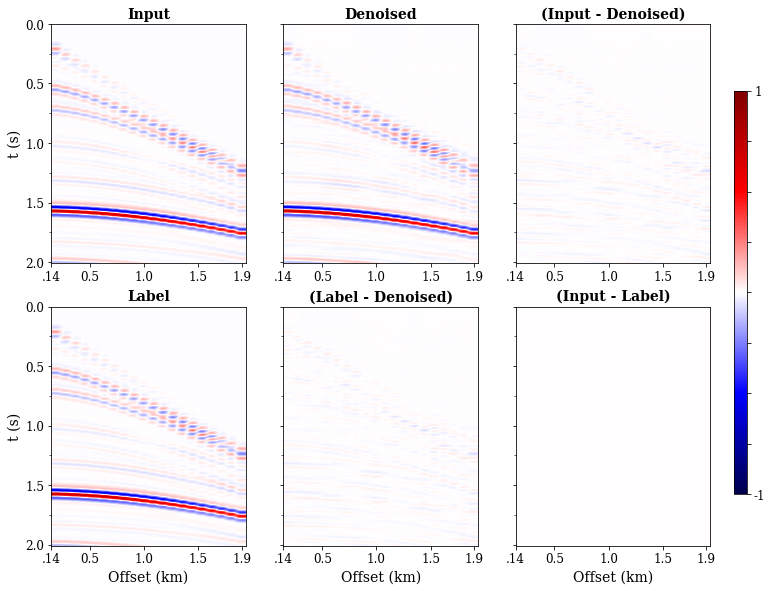

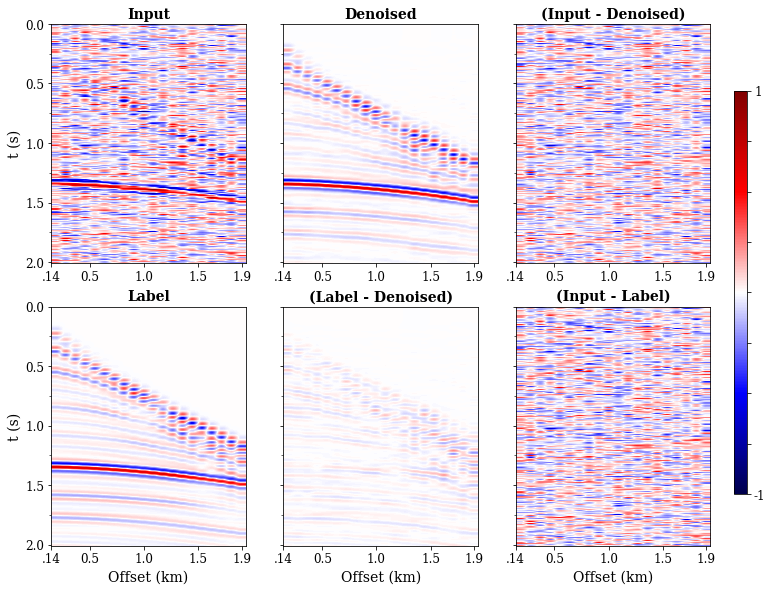

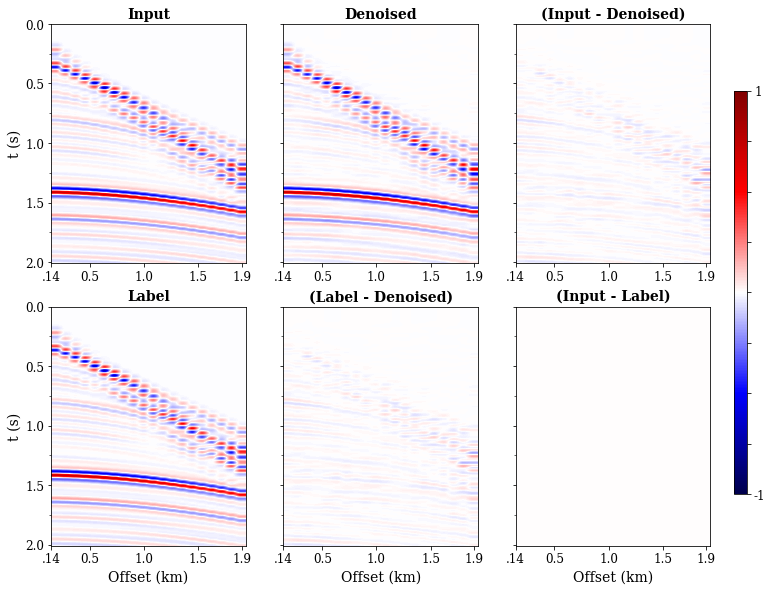

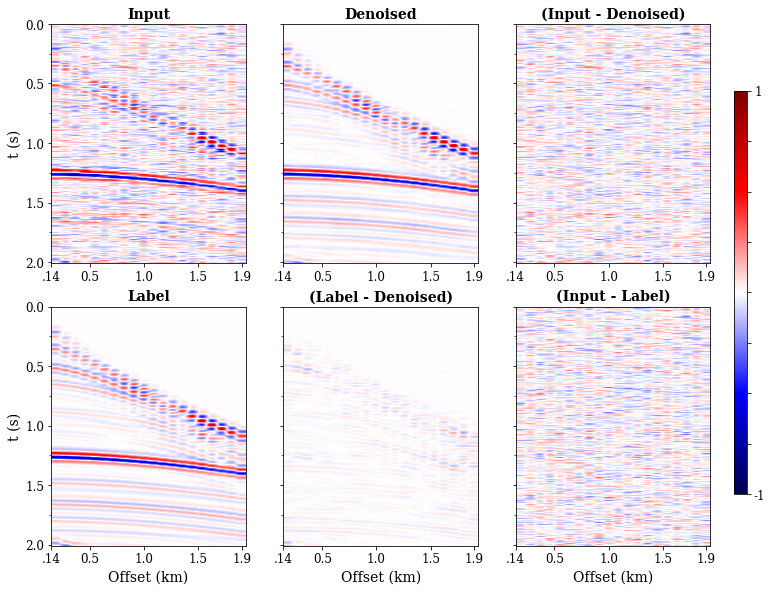

In [20]:
model.eval()

idx = torch.randint(len(test_data), (4,))
print(idx)

inputs_embeds = test_data.encodings['inputs_embeds'][idx]
labels = test_data.encodings['labels'][idx]
with torch.no_grad():
    sample_output = model(inputs_embeds=inputs_embeds.to(device).float())

for X, y, z in zip(inputs_embeds.cpu(), sample_output.logits.cpu(), labels.cpu()):
    f, ax = plt.subplots(2, 3, figsize=(10, 8), sharey=True, sharex=False)
    f.tight_layout()
    ax[0, 0].imshow(1 * (X - X.mean()).detach().swapaxes(0, 1) * 1, aspect=1.1, vmin=-1, vmax=1, cmap='seismic', 
                   extent=[x0, x0 + 20 * dx, 271 * dt, 0])
    ax[0, 0].set_title("Input", fontsize=14)
    ax[0, 0].set_xticks([x0, 0.5, 1, 1.5, 1.9])
    ax[0, 0].set_xticklabels([".14", "0.5", "1.0", "1.5", "1.9"])
    ax[0, 0].set_yticks(np.arange(0, 2.5, 0.5))
    ax[0, 0].yaxis.set_minor_locator(AutoMinorLocator(2))
    ax[0, 0].set_ylabel("t (s)")
    ax[0, 1].imshow(1 * (y - y.mean()).detach().swapaxes(0, 1) * 1, aspect=1.1, vmin=-1, vmax=1, cmap='seismic',
                   extent=[x0, x0 + 20 * dx, 271 * dt, 0])
    ax[0, 1].set_title("Denoised", fontsize=14)
    ax[0, 1].set_xticks([x0, 0.5, 1, 1.5, 1.9])
    ax[0, 1].set_xticklabels([".14", "0.5", "1.0", "1.5", "1.9"])
    ax[0, 1].set_yticks(np.arange(0, 2.5, 0.5))
    diff3 = 1 * (X - y)
    ax[0, 2].imshow((diff3 - diff3.mean()).detach().swapaxes(0, 1), aspect=1.1, vmin=-1, vmax=1, cmap='seismic',
                   extent=[x0, x0 + 20 * dx, 271 * dt, 0])
    ax[0, 2].set_title("(Input - Denoised)", fontsize=14)
    ax[0, 2].set_xticks([x0, 0.5, 1, 1.5, 1.9])
    ax[0, 2].set_xticklabels([".14", "0.5", "1.0", "1.5", "1.9"])
    ax[0, 2].set_yticks(np.arange(0, 2.5, 0.5))
    diff1 = z
    ax[1, 0].imshow(1 * (diff1 - diff1.mean()).detach().swapaxes(0, 1) * 1, aspect=1.1, vmin=-1, vmax=1, cmap='seismic',
                   extent=[x0, x0 + 20 * dx, 271 * dt, 0])
    ax[1, 0].set_title("Label", fontsize=14)
    ax[1, 0].set_xticks([x0, 0.5, 1, 1.5, 1.9])
    ax[1, 0].set_xticklabels([".14", "0.5", "1.0", "1.5", "1.9"])
    ax[1, 0].set_yticks(np.arange(0, 2.5, 0.5))
    ax[1, 0].yaxis.set_minor_locator(AutoMinorLocator(2))
    ax[1, 0].set_xlabel("Offset (km)")
    ax[1, 0].set_ylabel("t (s)")
    diff2 = 1 * (z - y)
    im4 = ax[1, 1].imshow((diff2 - diff2.mean()).detach().swapaxes(0, 1), aspect=1.1, vmin=-1, vmax=1, cmap='seismic',
                         extent=[x0, x0 + 20 * dx, 271 * dt, 0])
    ax[1, 1].set_title("(Label - Denoised)", fontsize=14)
    ax[1, 1].set_xticks([x0, 0.5, 1, 1.5, 1.9])
    ax[1, 1].set_xticklabels([".14", "0.5", "1.0", "1.5", "1.9"])
    ax[1, 1].set_yticks(np.arange(0, 2.5, 0.5))
    ax[1, 1].set_xlabel("Offset (km)")
    diff4 = 1 * (X - z)
    ax[1, 2].imshow((diff4 - diff4.mean()).detach().swapaxes(0, 1), aspect=1.1, vmin=-1, vmax=1, cmap='seismic',
                   extent=[x0, x0 + 20 * dx, 271 * dt, 0])
    ax[1, 2].set_title("(Input - Label)", fontsize=14)
    ax[1, 2].set_xticks([x0, 0.5, 1, 1.5, 1.9])
    ax[1, 2].set_xticklabels([".14", "0.5", "1.0", "1.5", "1.9"])
    ax[1, 2].set_yticks(np.arange(0, 2.5, 0.5))
    ax[1, 2].set_xlabel("Offset (km)")
    
    plt.ylim(2.01, 0)
    
    cbar_ax = f.add_axes([1, 0.15, 0.0175, 0.7])
    cbar = f.colorbar(im4, cax=cbar_ax)
    cbar.set_ticks(np.arange(-1, 1.25, .25))
    cbar.set_ticklabels([-1, "", "", "", "", "", "", "", 1])

## Finalize

In [21]:
# Save everything
print("Saving to", config.parent_dir)
if os.path.exists(os.path.join(config.parent_dir, 'model.pt')):
    if input("Path exists. Overwrite? (y/n)") == 'y':
        torch.save(model, os.path.join(config.parent_dir, 'model.pt'))
        avg_train_loss_arr = np.array(avg_train_loss)
        avg_valid_loss_arr = np.array(avg_valid_loss)
        np.save(os.path.join(config.parent_dir, 'train_loss.npy'), avg_train_loss_arr)
        np.save(os.path.join(config.parent_dir, 'valid_loss.npy'), avg_valid_loss_arr)
        torch.save(config, os.path.join(config.parent_dir, 'config.pt'))
        print("Saved successfully to", config.parent_dir)
    else:
        print("Saving failed.")
else:
    torch.save(model, os.path.join(config.parent_dir, 'model.pt'))
    avg_train_loss_arr = np.array(avg_train_loss)
    avg_valid_loss_arr = np.array(avg_valid_loss)
    np.save(os.path.join(config.parent_dir, 'train_loss.npy'), avg_train_loss_arr)
    np.save(os.path.join(config.parent_dir, 'valid_loss.npy'), avg_valid_loss_arr)
    torch.save(config, os.path.join(config.parent_dir, 'config.pt'))
    print("Saved successfully to", config.parent_dir)

Saving to ./results/finetune/denoising/
Saved successfully to ./results/finetune/denoising/
